### Phone Recommendation system


In [1]:
import os

In [2]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class DataTransformConfig:
    root_dir: Path
    processed_data_file: Path
    transform_data_file: Path

In [6]:
from phone_recommender.constants import *
from phone_recommender.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

    def get_data_transform_config(self) -> DataTransformConfig:
        config = self.config.data_transform

        create_directories([config.root_dir])

        data_transform_config = DataTransformConfig(
            root_dir=config.root_dir,
            processed_data_file=config.processed_data_file,
            transform_data_file=config.transform_data_file,
        )

        return data_transform_config

In [8]:
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phone_recommender.logging import logger


warnings.filterwarnings('ignore')

In [9]:
class DataTransform:
    def __init__(self, config: DataTransformConfig) -> None:
        self.config = config

        create_directories([self.config.root_dir])

    def get_processed_data(self):
        processed_data_file = self.config.processed_data_file
        if not os.path.exists(processed_data_file):
            logger.info("No processed data file exists please check if data extraction is complete!")
        else:
            df = pd.read_csv(processed_data_file)
            return df

    def save_transformed_data(self, df: pd.DataFrame):
        df.to_csv(self.config.transform_data_file, index=False)

In [10]:
try:
    config = ConfigurationManager()
    data_transform_config = config.get_data_transform_config()
    data_transform = DataTransform(data_transform_config)
    df = data_transform.get_processed_data()
except Exception as e:
    raise e

[2023-12-07 02:05:48,483: INFO: common: yaml file: config\config.yaml loads successfully]
[2023-12-07 02:05:48,485: INFO: common: yaml file: params.yaml loads successfully]
[2023-12-07 02:05:48,487: INFO: common: created directory at : artifacts/data_transform]
[2023-12-07 02:05:48,489: INFO: common: created directory at : artifacts/data_transform]


### Data Transformation


In [11]:
df.head()

,brand,phone_name,text,network,4g_bands,4g_band_count,5g_bands,5g_band_count,released_year,height_width_depth,...,display_size,display_type,os,chipset,ram,storage,main_camera,selfie_camera,bluetooth,battery
0,huawei,nova 11 SE,network technology gsm / cdma / hspa / cdma200...,lte,1 3 4 5 8 18 19 26 34 38 39 40,12,0,0,2023,162.4 75.5 7.4,...,6.7,oled 90hz,harmony4.0,snapdragon680,0,0,108mp,32mp,bluetooth5.0,4500mah
1,huawei,Mate 60 Pro+,network technology gsm / cdma / hspa / cdma200...,lte 5g,1,1,1,1,2023,163.7 79 8.1,...,6.8,ltpo oled 120hz,harmony4.0,kirin9000s,16gb,512gb 1tb ufs,48mp,13mp,bluetooth5.2,5000mah
2,huawei,Mate X5,network technology gsm / cdma / hspa / evdo / ...,lte 5g,1,1,1,1,2023,156.9 141.5 5.3,...,7.8,oled 120hz,harmony4.0,kirin9000s,12gb 16gb,256gb 512gb 512gb 1tb ufs,50mp,8mp,bluetooth5.2,5060mah
3,huawei,Mate 60 Pro,network technology gsm / cdma / hspa / cdma200...,lte 5g,1,1,1,1,2023,163.7 79 8.1,...,6.8,ltpo oled 120hz,harmony4.0,kirin9000s,12gb,256gb 512gb 1tb ufs,50mp,13mp,bluetooth5.2,5000mah
4,huawei,nova Y91,network technology gsm / hspa / lte 2g bands g...,lte,1 2 3 4 5 7 8 13 20 26 28 38 40 41,14,0,0,2023,171.6 79.9 8.9,...,7.0,ips lcd 90hz,emui13,snapdragon680,6gb 8gb,128gb 128gb 256gb,50mp,8mp,bluetooth5.0,7000mah


In [12]:
df.select_dtypes(include="object").columns

Index(['brand', 'phone_name', 'text', 'network', '4g_bands', '5g_bands',
       'released_year', 'height_width_depth', 'resolution', 'display_type',
       'os', 'chipset', 'ram', 'storage', 'main_camera', 'selfie_camera',
       'bluetooth', 'battery'],
      dtype='object')

In [13]:
df['display_size_str'] = df['display_size_str'].astype('str')

In [14]:
df.select_dtypes(include="object").columns

Index(['brand', 'phone_name', 'text', 'network', '4g_bands', '5g_bands',
       'released_year', 'height_width_depth', 'resolution', 'display_size_str',
       'display_type', 'os', 'chipset', 'ram', 'storage', 'main_camera',
       'selfie_camera', 'bluetooth', 'battery'],
      dtype='object')

In [15]:
df_cate = df[
    [
        'brand',
        'phone_name',
        'text',
        'network',
        '4g_bands',
        '5g_bands',
        'released_year',
        'height_width_depth',
        'resolution',
        'display_size_str',
        'display_type',
        'os',
        'chipset',
        'ram',
        'storage',
        'main_camera',
        'selfie_camera',
        'bluetooth',
        'battery',
    ]
]

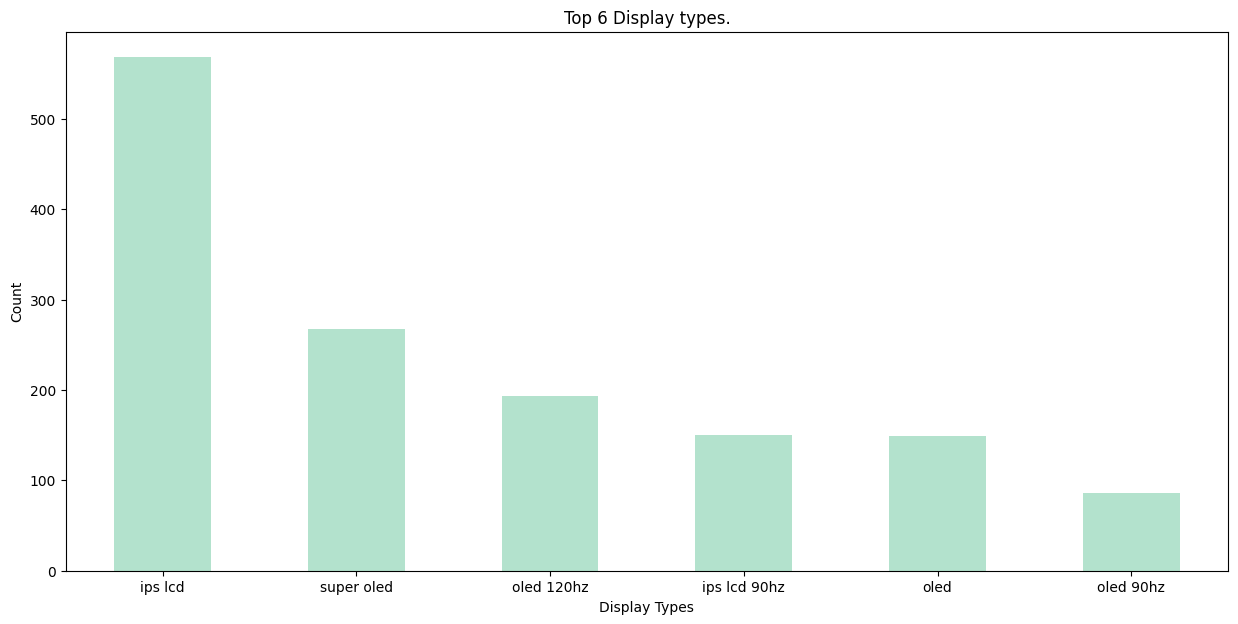

In [16]:
plt.figure(figsize=(15, 7))
df['display_type'].value_counts().head(6).plot(
    kind='bar',
    colormap='Pastel2',
    rot=360,
    xlabel="Display Types",
    title="Top 6 Display types.",
    ylabel="Count",
    fontsize=10,
)

plt.show()

- Analysis:
  - Most common type of display used in mobile phone is ips panel.
  - Followed by super oled which is better than ips in terms of brightness and color contrast.


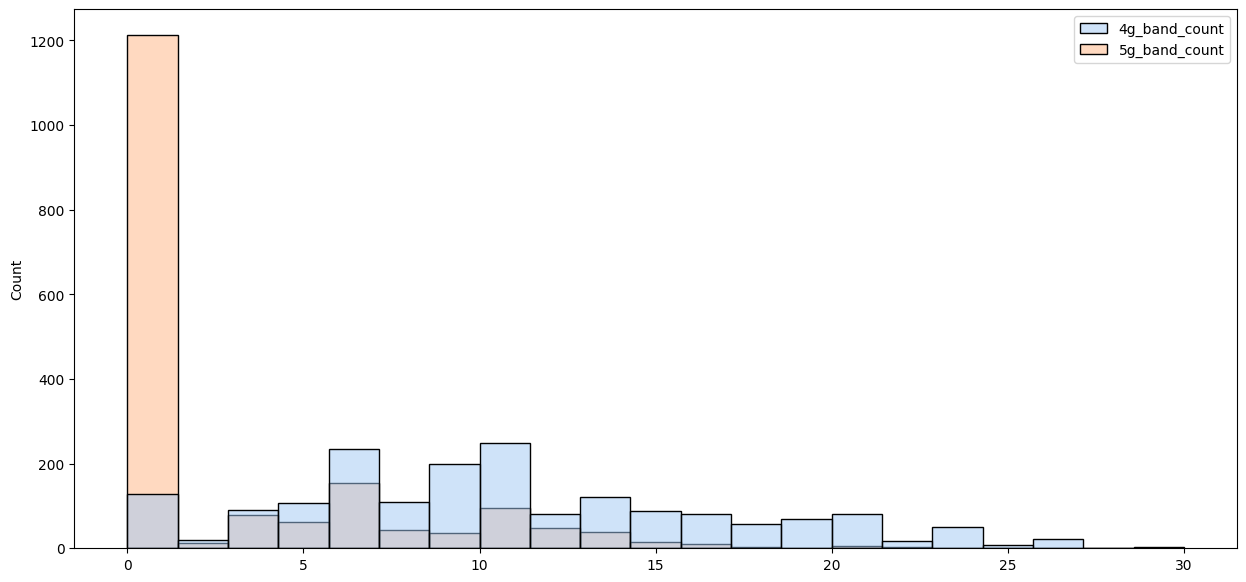

In [17]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df[['4g_band_count', '5g_band_count']], palette='pastel')
plt.show()

- Analysis
  - A lot of phones don't have 5g bands in our data set.
  - And also most of the phones have bands in between 5 to 15 may the phone be 5g or 4g.


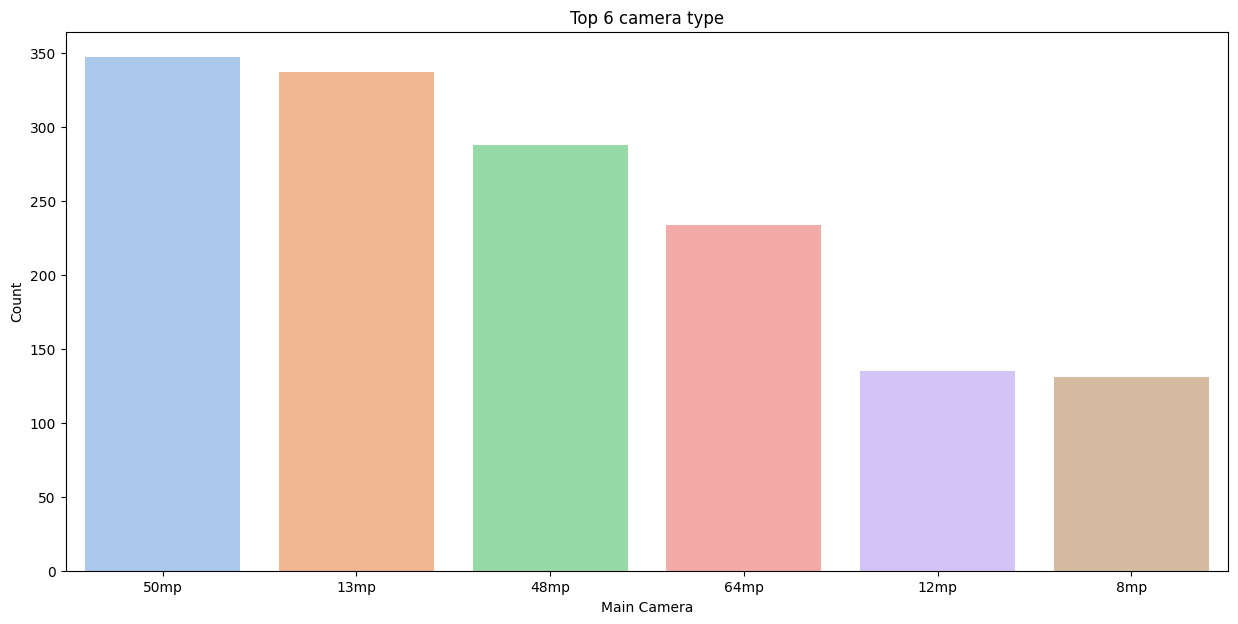

In [18]:
plt.figure(figsize=(15, 7))
sns.barplot(df['main_camera'].value_counts().head(6), palette='pastel')
plt.title("Top 6 camera type")
plt.xlabel("Main Camera")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So 50mp, 13mp followed by 48mp can be seen in a lot of phones with respect to data.
  - Note: the camera mega pixel don't matter a lot when it comes to the picture quality but also the camera app which plays the most important role in making the image as these cameras heavily relies on the AI to process the image.


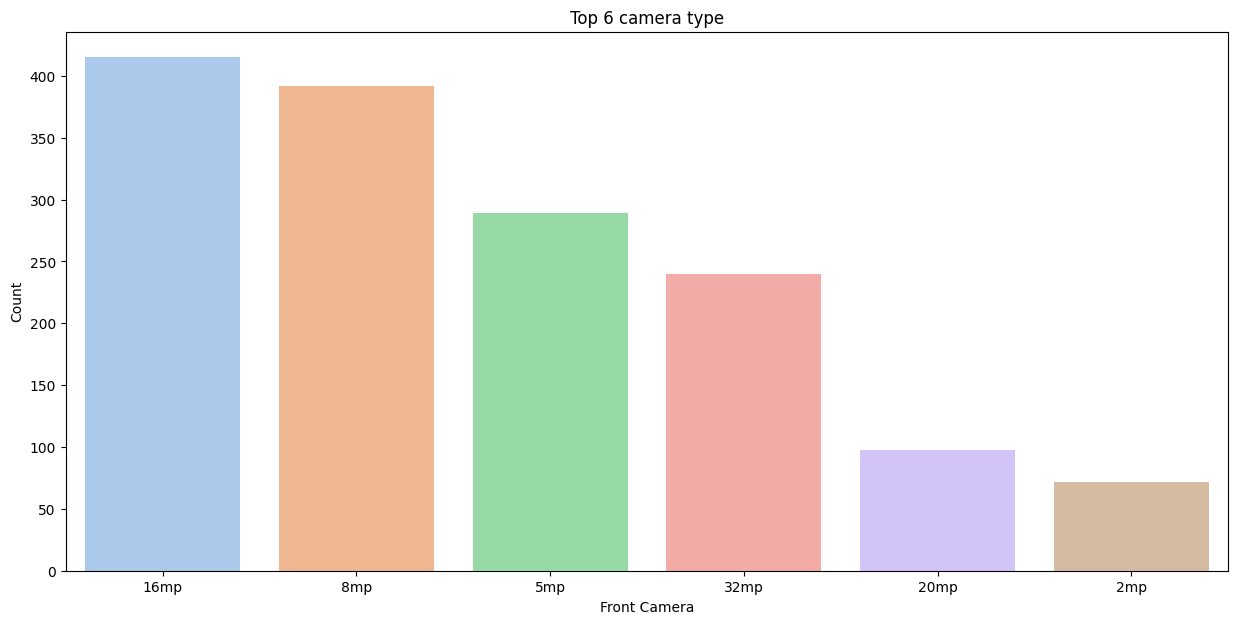

In [19]:
plt.figure(figsize=(15, 7))
sns.barplot(df['selfie_camera'].value_counts().head(6), palette='pastel')
plt.title("Top 6 camera type")
plt.xlabel("Front Camera")
plt.ylabel("Count")
plt.show()

- Analysis:
  - In terms of front camera the 16mp and 8mp is the most common choice.


[2023-12-07 02:05:49,526: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2023-12-07 02:05:49,533: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


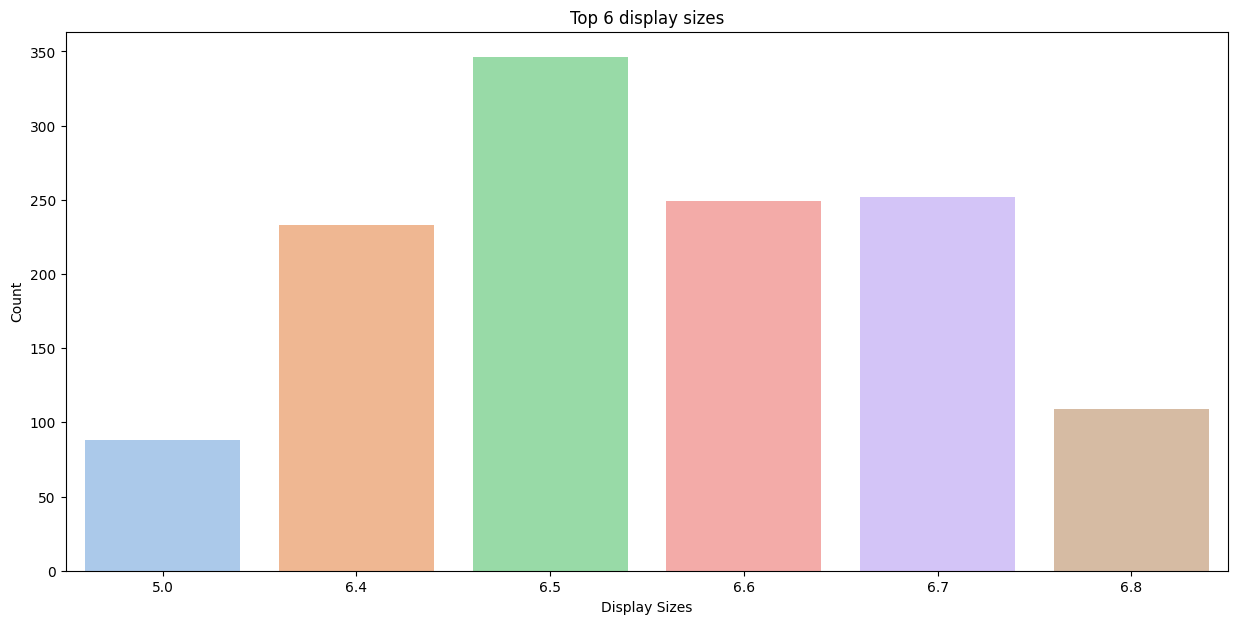

In [20]:
plt.figure(figsize=(15, 7))
sns.barplot(df['display_size'].value_counts().head(6), palette='pastel')
plt.title("Top 6 display sizes")
plt.xlabel("Display Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So as we can see as of now the most common display size is 6.5 inch followed by 6.7 and 6.6.
  - The pattern here that we can see is the now brands are moving towards bigger displays from smaller once.


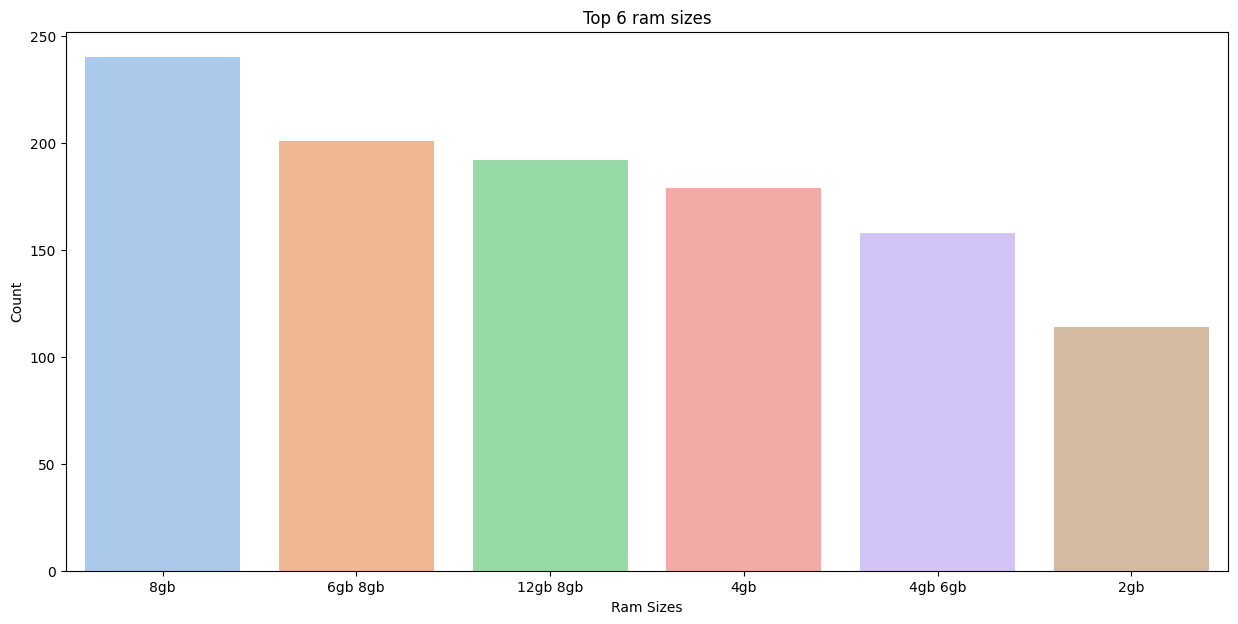

In [21]:
plt.figure(figsize=(15, 7))
sns.barplot(df['ram'].value_counts().head(6), palette='pastel')
plt.title("Top 6 ram sizes")
plt.xlabel("Ram Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So as we can see that a lot of phones offer ram from 6gb to 12gb.
  - With 8gb being the most common option.


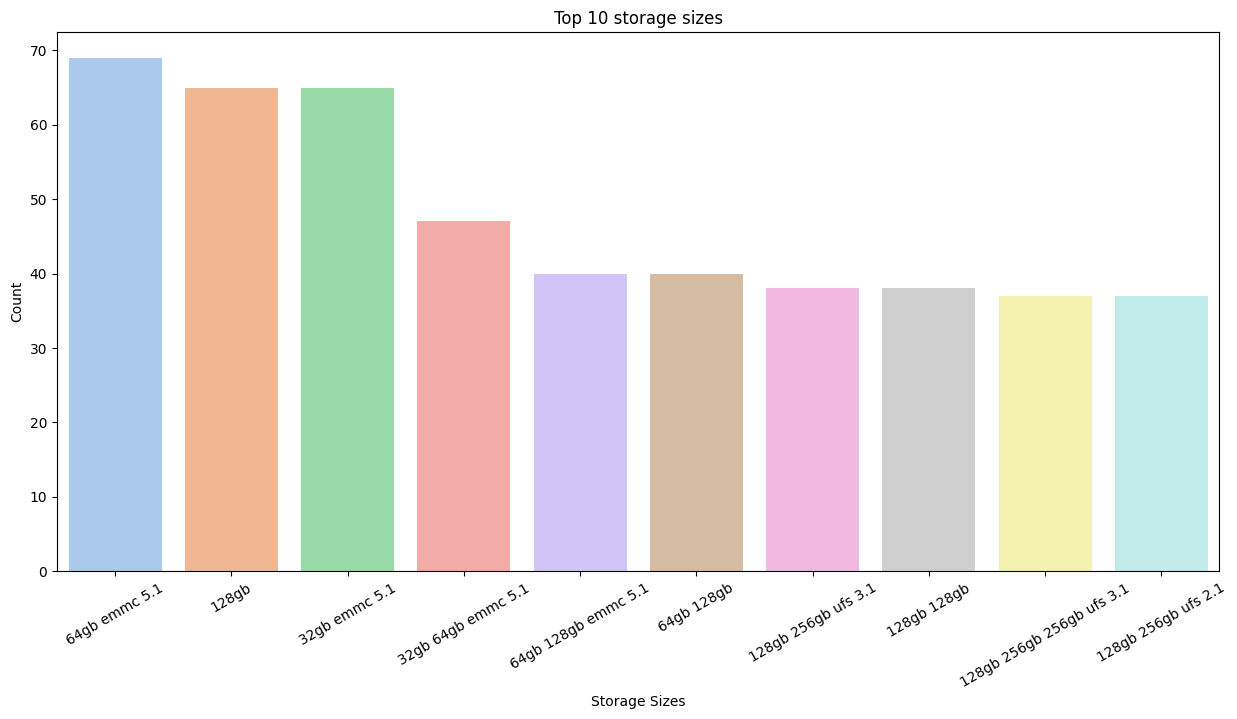

In [22]:
plt.figure(figsize=(15, 7))
sns.barplot(df['storage'].value_counts().head(10), palette='pastel')
plt.xticks(rotation=30)
plt.title("Top 10 storage sizes")
plt.xlabel("Storage Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - In todays world of growing file sizes we can see that 64gb and 128 gb config are the most common.


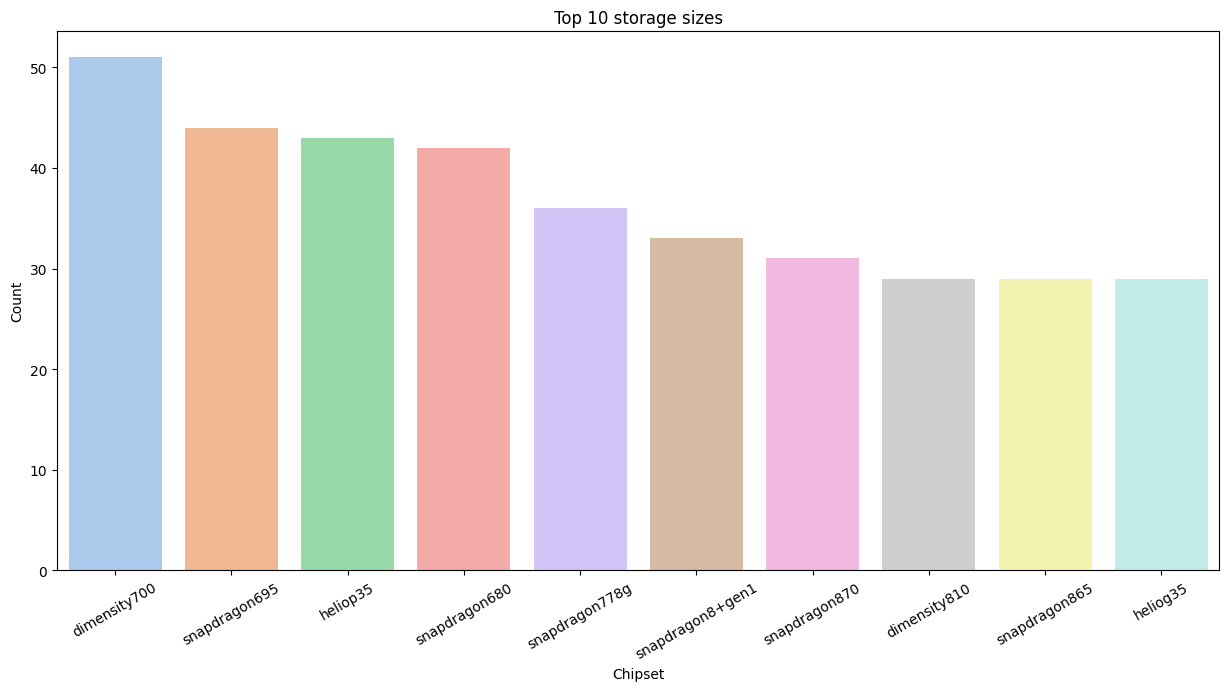

In [23]:
plt.figure(figsize=(15, 7))
sns.barplot(df['chipset'].value_counts()[1:].head(10), palette='pastel')
plt.xticks(rotation=30)
plt.title("Top 10 storage sizes")
plt.xlabel("Chipset")
plt.ylabel("Count")
plt.show()

- Analysis:
  - Top 10 chipset used by phone manufactures.


#### Data Transform


In [24]:
df_cate.columns

Index(['brand', 'phone_name', 'text', 'network', '4g_bands', '5g_bands',
       'released_year', 'height_width_depth', 'resolution', 'display_size_str',
       'display_type', 'os', 'chipset', 'ram', 'storage', 'main_camera',
       'selfie_camera', 'bluetooth', 'battery'],
      dtype='object')

In [25]:
df_cate.shape

(1819, 19)

In [26]:
df_trans = df_cate[
    [
        'brand',
        'network',
        'released_year',
        'resolution',
        'display_size_str',
        'display_type',
        'os',
        'chipset',
        'ram',
        'storage',
        'main_camera',
        'selfie_camera',
        'bluetooth',
        'battery',
    ]
]

In [27]:
df_trans.shape

(1819, 14)

In [28]:
df_trans['text'] = df_trans.apply(lambda row: " ".join(map(str, row)), axis=1)

In [29]:
df_trans['text'][0]

'huawei lte 2023 1080 2400 6.7 oled 90hz harmony4.0 snapdragon680 0 0 108mp 32mp bluetooth5.0 4500mah'

In [30]:
def remove_extra_space(text):
    res = " ".join(text.split())
    return res

In [31]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
df_trans['text'] = df_trans['text'].apply(lambda x: remove_extra_space(x))

In [33]:
df_trans['text'] = df_trans['text'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:
cv = CountVectorizer()
df_cv = cv.fit_transform(df_trans['text'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(df_cv, columns=cv.get_feature_names_out())
tdm = df_dtm.T
tdm.shape

(669, 1819)

In [36]:
tdm['freq'] = tdm.sum(axis=1)
tdm.reset_index(inplace=True)
tdm.rename(columns={'index': 'words'}, inplace=True)

In [37]:
tdm1 = tdm[['words', 'freq']]
tdm1 = tdm1.sort_values('freq', ascending=False)
tdm1.reset_index(inplace=True)
tdm1.drop("index", inplace=True, axis=1)
tdm1.head(20)

,words,freq
0,lte,1820
1,128gb,1532
2,1080,1041
3,lcd,918
4,8gb,871
5,oled,842
6,256gb,822
7,ips,817
8,ufs,765
9,64gb,687


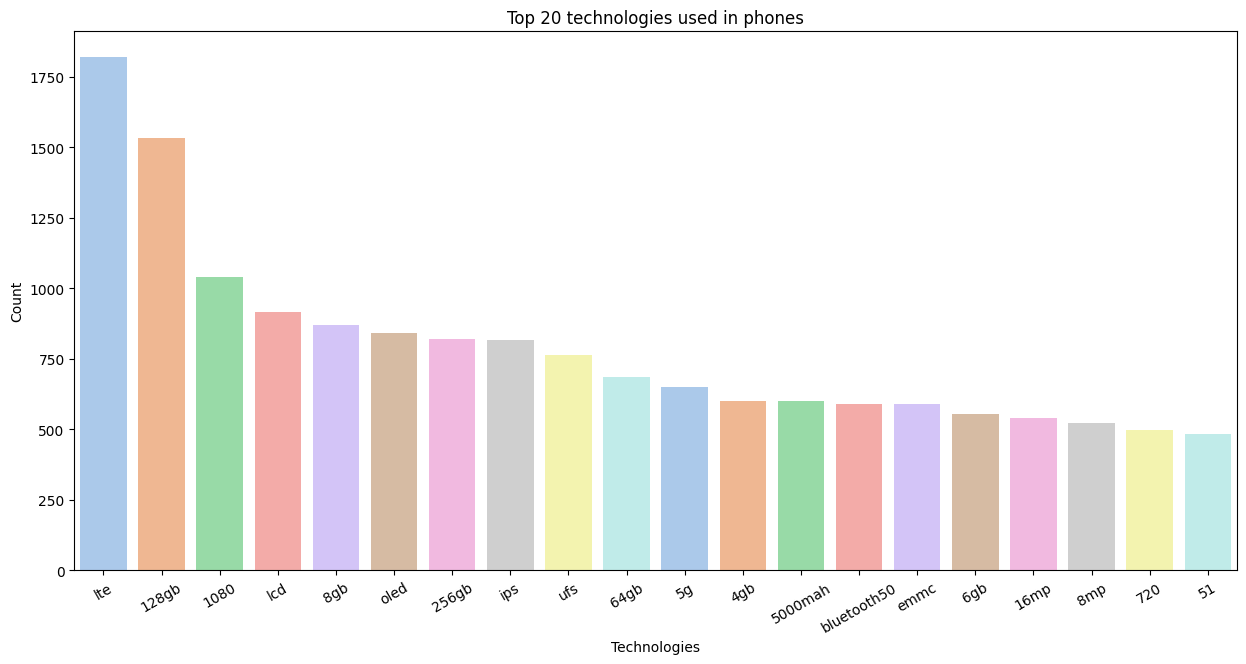

In [38]:
plt.figure(figsize=(15, 7))
sns.barplot(x=tdm1['words'].head(20), y=tdm1['freq'].head(20), palette='pastel')
plt.title("Top 20 technologies used in phones")
plt.xlabel("Technologies")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

In [39]:
ssd = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_dtm)
    scr = kmeans.score(df_dtm)
    ssd.append(scr)
    print(f"cluster number {i} cluster remaining {10 - i}")

cluster number 1 cluster remaining 9
cluster number 2 cluster remaining 8
cluster number 3 cluster remaining 7
cluster number 4 cluster remaining 6
cluster number 5 cluster remaining 5
cluster number 6 cluster remaining 4
cluster number 7 cluster remaining 3
cluster number 8 cluster remaining 2
cluster number 9 cluster remaining 1
cluster number 10 cluster remaining 0


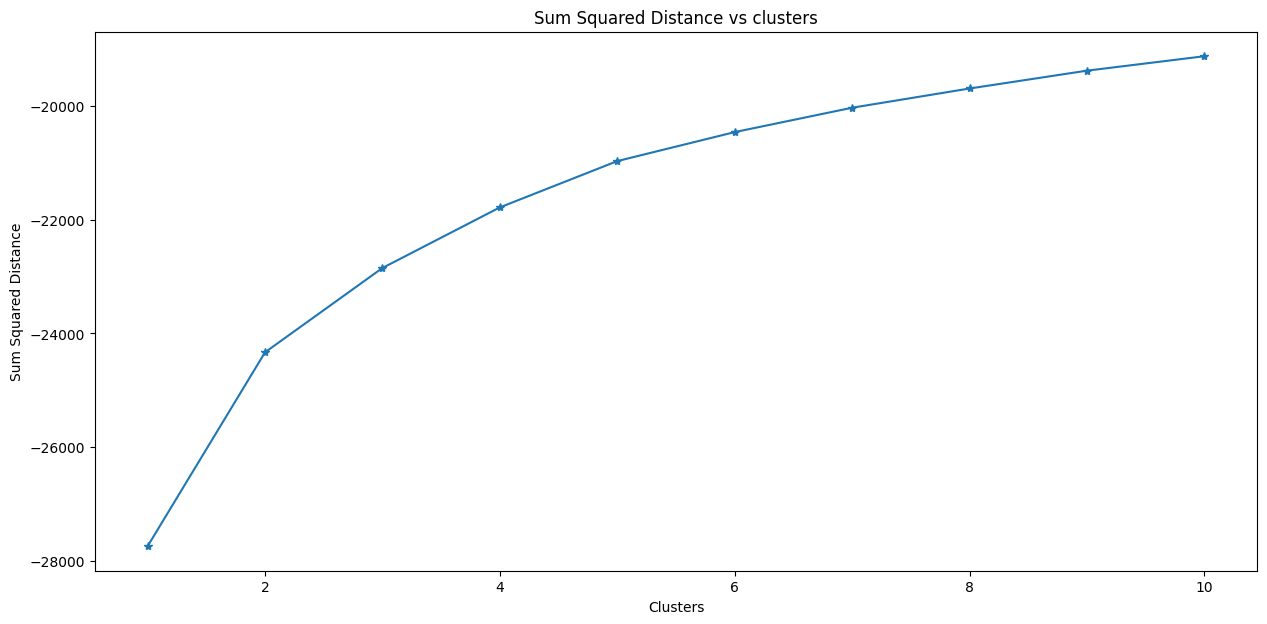

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(range(1, 11), ssd, "-*")
plt.title("Sum Squared Distance vs clusters")
plt.xlabel("Clusters")
plt.ylabel("Sum Squared Distance")
plt.show()

In [41]:
ssd = np.array(ssd)
(ssd[:-1] - ssd[1:]) * 100 / ssd[:-1]

array([12.27791838,  6.08782282,  4.65692523,  3.7318604 ,  2.42709758,
        2.09144677,  1.68563543,  1.59033177,  1.30758557])

In [42]:
clusters = KMeans(n_clusters=3, random_state=42).fit_predict(df_dtm)

In [43]:
sil_val = silhouette_samples(df_dtm, clusters)
sil_df = pd.DataFrame()
sil_df['cluster'] = clusters
sil_df['score'] = sil_val

In [44]:
error = sil_df[sil_df['score'] < 0]
len(error)

17

In [45]:
np.sqrt(np.mean(np.square(0 - error['score'])))

0.005187690686840956

In [46]:
idf = TfidfVectorizer()
df_tfidf = idf.fit_transform(df_trans['text'])
tfidf = pd.DataFrame.sparse.from_spmatrix(df_tfidf, columns=idf.get_feature_names_out())
tfidf.head()

,00,10,100mp,101,1080,1084,108mp,10gb,10mp,112gb,...,tft,tizen24,tizen55,tn,ufs,user,v6,vivo,xiaomi,еmmc
0,0.0,0.0,0.0,0.0,0.123032,0.0,0.316469,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.101489,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.086374,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.101212,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.097084,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [47]:
ssd = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf)
    scr = kmeans.score(tfidf)
    ssd.append(scr)
    print(f"cluster number {i} cluster remaining {10 - i}")

cluster number 1 cluster remaining 9
cluster number 2 cluster remaining 8
cluster number 3 cluster remaining 7
cluster number 4 cluster remaining 6
cluster number 5 cluster remaining 5
cluster number 6 cluster remaining 4
cluster number 7 cluster remaining 3
cluster number 8 cluster remaining 2
cluster number 9 cluster remaining 1
cluster number 10 cluster remaining 0


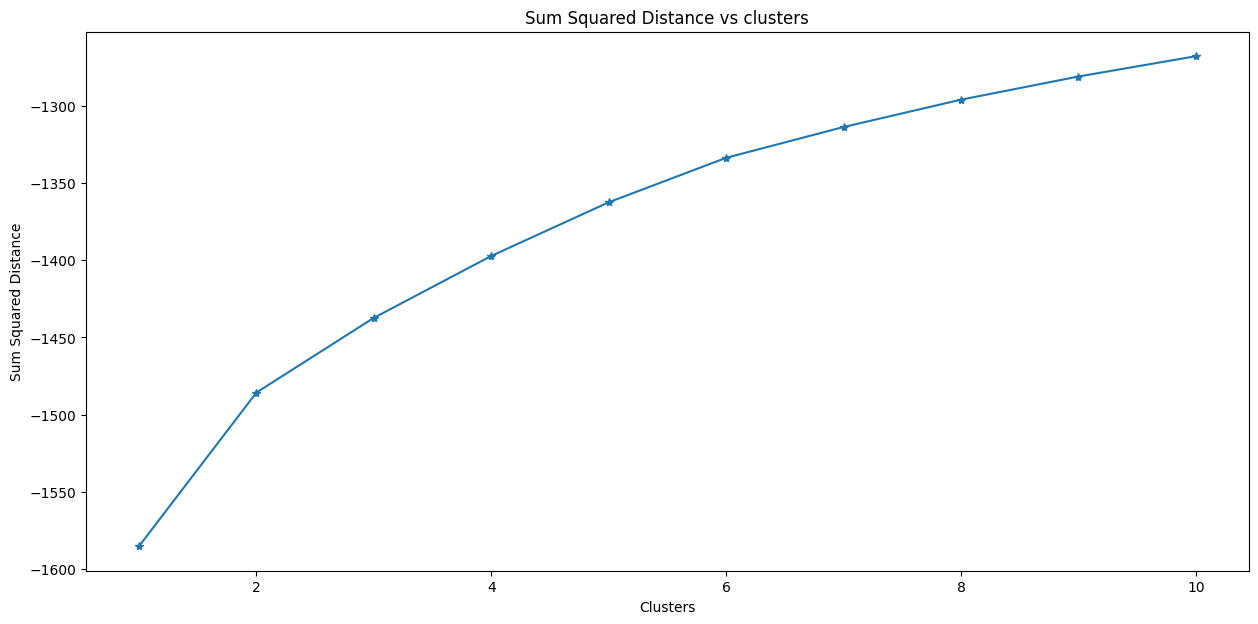

In [48]:
plt.figure(figsize=(15, 7))
plt.plot(range(1, 11), ssd, "-*")
plt.title("Sum Squared Distance vs clusters")
plt.xlabel("Clusters")
plt.ylabel("Sum Squared Distance")
plt.show()

In [49]:
ssd = np.array(ssd)
(ssd[:-1] - ssd[1:]) * 100 / ssd[:-1]

array([6.27722839, 3.25566985, 2.7883577 , 2.48688147, 2.11336911,
       1.49518906, 1.34705249, 1.15760155, 1.02583004])

In [50]:
cluster2 = KMeans(n_clusters=2, random_state=42).fit_predict(tfidf)

In [51]:
sil_val = silhouette_samples(tfidf, clusters)
sil_df = pd.DataFrame()
sil_df['cluster'] = clusters
sil_df['score'] = sil_val

In [52]:
error = sil_df[sil_df['score'] < 0]
len(error)

136

In [53]:
np.sqrt(np.mean(np.square(0 - error['score'])))

0.019004023510636996

- Count Vectorizer is working good for clustering our data as compared to tfidf.
- And also count vectorizer is able to cluster data in 3 cluster as compared to 2 in tfidf.


In [54]:
df_trans['class'] = clusters

In [55]:
data_transform.save_transformed_data(df_trans)

In [56]:
dfc1 = df_trans[df_trans['class'] == 0]
dfc2 = df_trans[df_trans['class'] == 1]
dfc3 = df_trans[df_trans['class'] == 2]

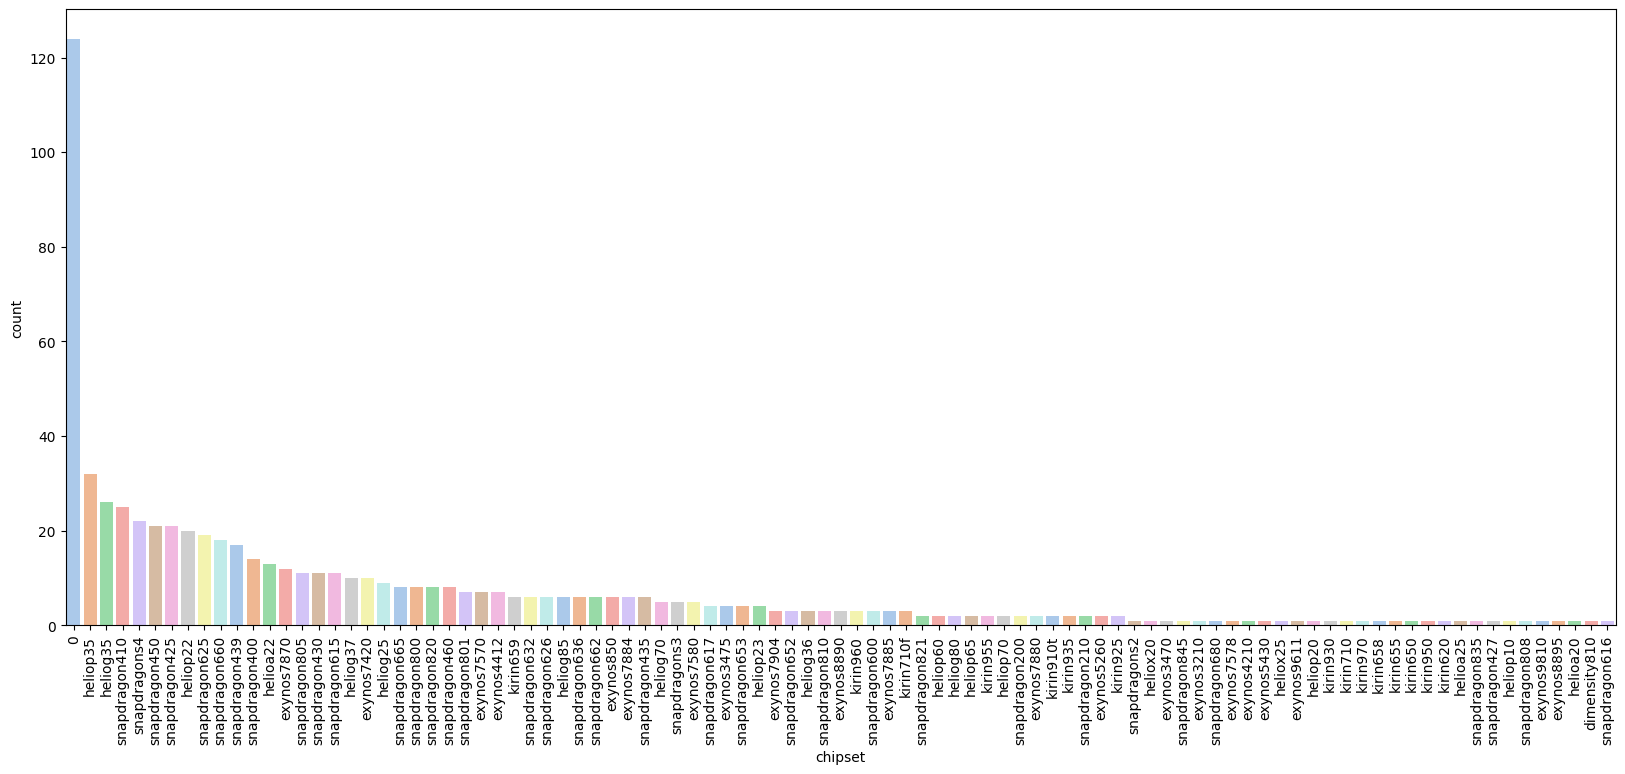

In [57]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc1['chipset'].value_counts(), palette='pastel')
plt.xticks(rotation=90)
plt.show()

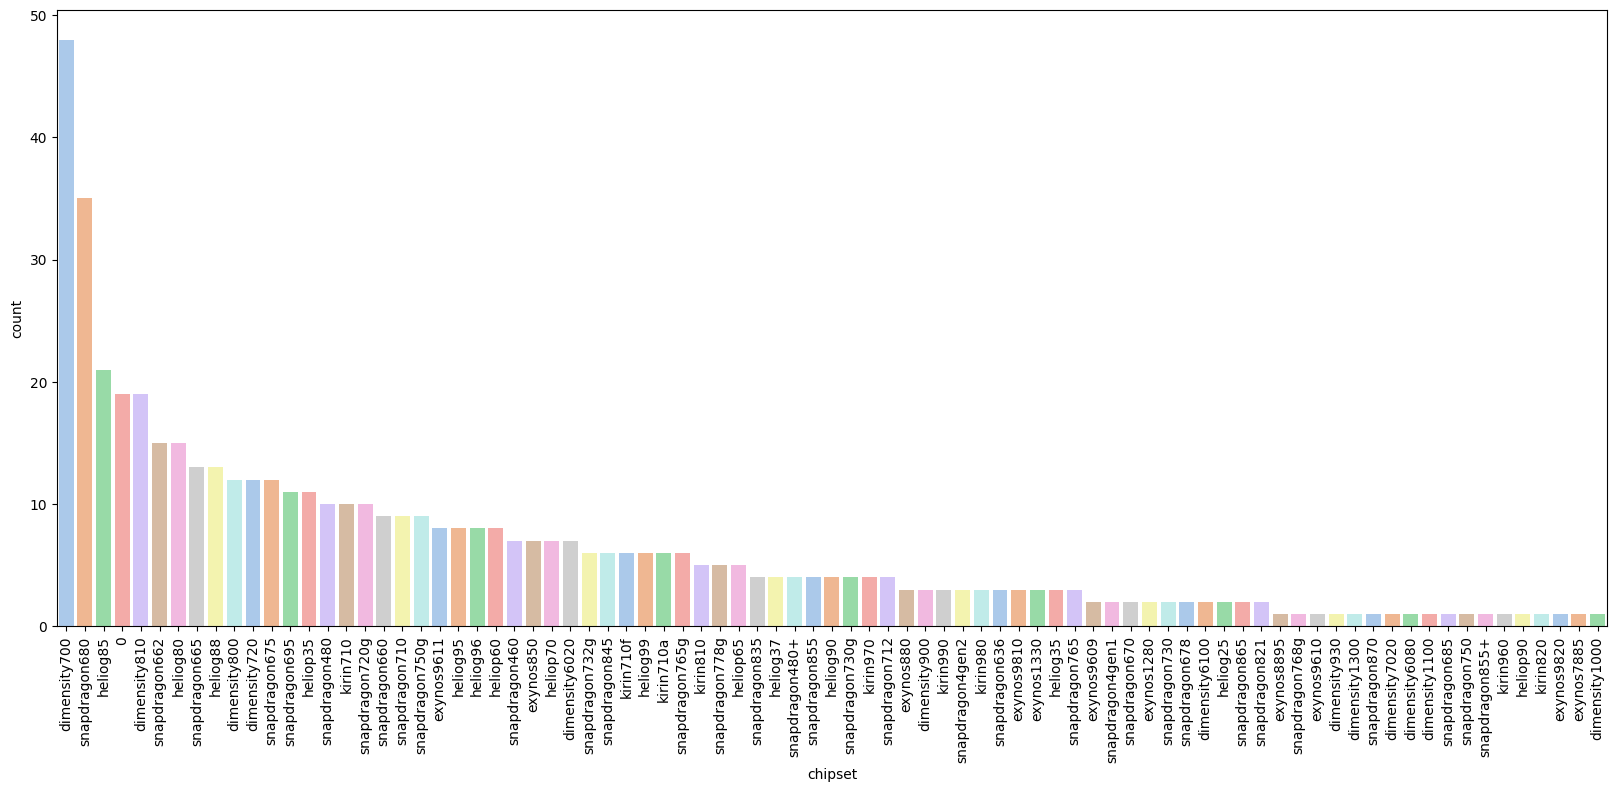

In [58]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc2['chipset'].value_counts(), palette='pastel')
plt.xticks(rotation=90)
plt.show()

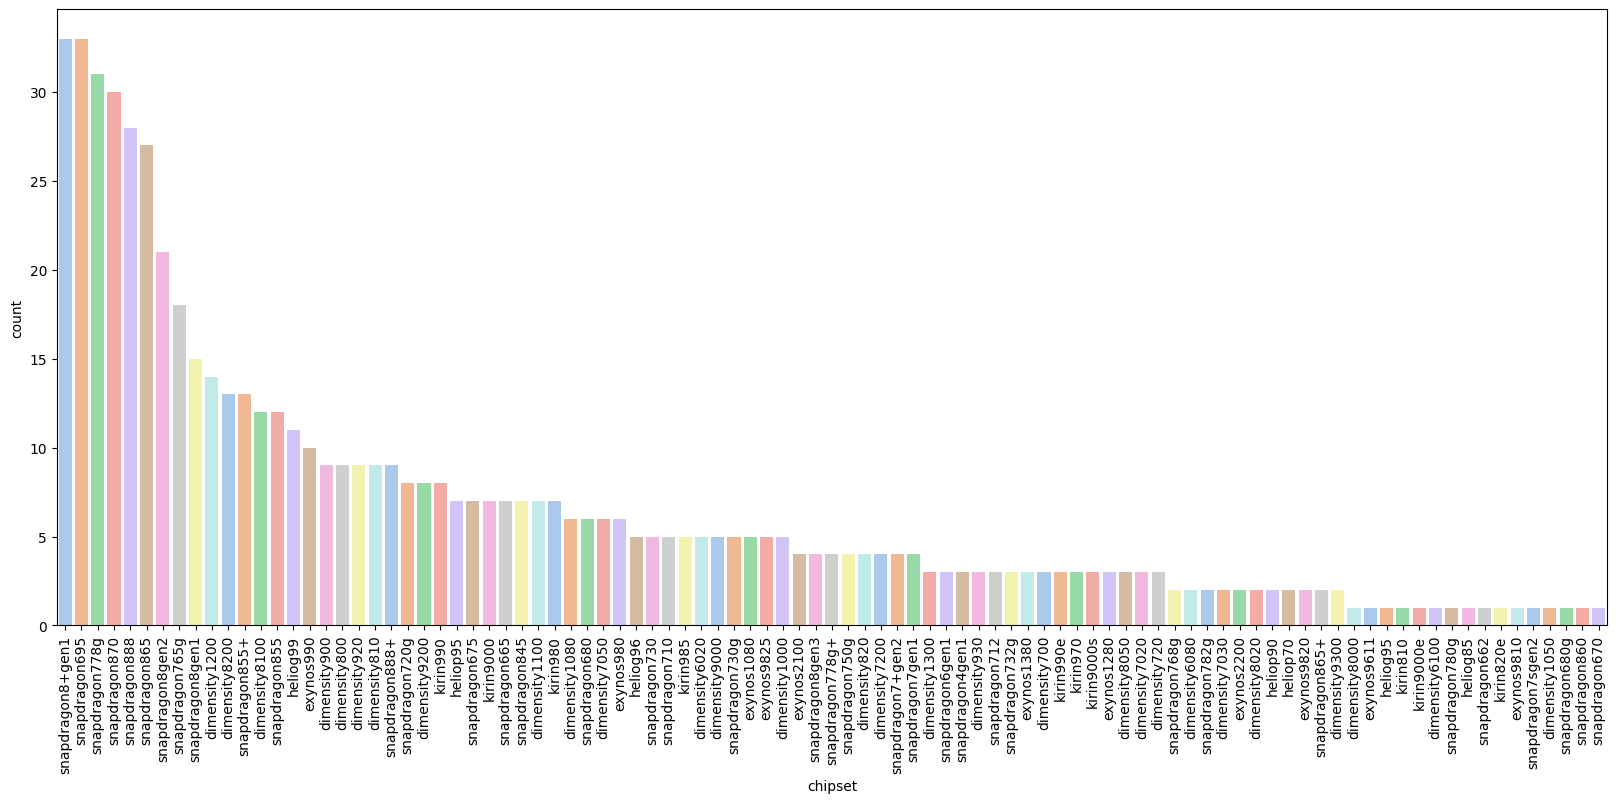

In [59]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc3['chipset'].value_counts(), palette="pastel")
plt.xticks(rotation=90)
plt.show()